# Process dataset for use with Deep Learning segmentation network
> A guide for processing raster data and labels into ML-ready format for use with a deep-learning based semantic segmentation.

## Setup Notebook

In [1]:
# install required libraries
!pip install -q rasterio
!pip install -q geopandas

     |████████████████████████████████| 19.3 MB 142 kB/s 
     |████████████████████████████████| 1.0 MB 8.3 MB/s 
     |████████████████████████████████| 6.3 MB 31.6 MB/s 
     |████████████████████████████████| 15.4 MB 36.9 MB/s 


In [2]:
# import required libraries
import os, glob, functools, fnmatch, json, requests
from zipfile import ZipFile
from itertools import product
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio import features, mask, windows

import geopandas as gpd

from IPython.display import clear_output

import cv2

In [3]:
#authenticate Google Cloud Storage
from google.colab import auth
auth.authenticate_user()
print("...done")

...done


In [4]:
# Mount google drive.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
# Set your root directory, and project level directories.
root_dir = '/content/gdrive/My Drive/servir-tf/' 
terrabio_dir = root_dir+'terrabio'
rami_dir = root_dir+'rami'

In [13]:
dirs = [root_dir, terrabio_dir, rami_dir]

In [14]:
for dir in dirs:
  if not os.path.exists(dir):
    os.makedirs(root_dir)

## Import necessary data from Google Cloud Storage

If you have shared your email, you should be able to access the project listed below and all of the data in the indicated bucket.

*Let's test a singe file*

In [37]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
project = 'servirtensorflow'
storage_client = storage.Client(project=project)

# The name for the new bucket
bucket_name = "dev-seed-workshop"

# Creates the new bucket

def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"

    # The ID of your GCS object
    # source_blob_name = "storage-object-name"

    # The path to which the file should be downloaded
    # destination_file_name = "local/path/to/file"

    bucket = storage_client.bucket(bucket_name)

    # Construct a client side representation of a blob.
    # Note `Bucket.blob` differs from `Bucket.get_blob` as it doesn't retrieve
    # any content from Google Cloud Storage. As we don't need additional data,
    # using `Bucket.blob` is preferred here.
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Downloaded storage object {} from bucket {} to local file {}.".format(
            source_blob_name, bucket_name, destination_file_name
        )
    )

source_blob_name = 'terrabio/data/terrabio_classes.csv'
terrabio_data_dir = terrabio_dir+'/data/'
terrabio_gcs_to_local_dir = terrabio_data_dir+'gcs/'
dirs = [terrabio_data_dir, terrabio_gcs_to_local_dir]
for dir in dirs:
  if not os.path.exists(dir):
    os.makedirs(root_dir)
destination_file_name = terrabio_gcs_to_local_dir+'terrabio_classes.csv'
download_blob(bucket_name, source_blob_name, destination_file_name)

Downloaded storage object terrabio/data/terrabio_classes.csv from bucket dev-seed-workshop to local file /content/gdrive/My Drive/servir-tf/terrabio/data/gcs/terrabio_classes.csv.


Now, let's download the tiled indices. This may take some time.

In [ ]:
prefix = 'terrabio/data/tiled/indices/'
local_dir = terrabio_gcs_to_local_dir+'tiled/indices/'
terrabio_gcs_tiled_dir = terrabio_gcs_to_local_dir+'tiled/'
terrabio_gcs_tiled_indices_dir = terrabio_gcs_tiled_dir+'indices/'
dirs = [terrabio_gcs_tiled_dir, terrabio_gcs_tiled_indices_dir]
for dir in dirs:
  if not os.path.exists(dir):
    os.makedirs(dir)


bucket_name = "dev-seed-workshop"
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
for blob in blobs:
    filename = blob.name.replace('/', '_') 
    blob.download_to_filename(local_dir + filename)  # Download
    #print(blob, filename)

...and the tiled labels.

In [ ]:
prefix = 'terrabio/data/tiled/labels/'
local_dir = terrabio_gcs_tiled_dir+'labels/'
terrabio_gcs_tiled_labels_dir = terrabio_gcs_tiled_dir+'labels/'
if not os.path.exists(terrabio_gcs_tiled_labels_dir):
  os.makedirs(terrabio_gcs_tiled_labels_dir)


bucket_name = "dev-seed-workshop"
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
for blob in blobs:
    filename = blob.name.replace('/', '_') 
    blob.download_to_filename(local_dir + filename)  # Download
    #print(blob, filename)

Lastly, let's get a list of the background tiles.

In [32]:
source_blob_name = 'terrabio/data/background_list_train.txt'
destination_file_name = terrabio_gcs_to_local_dir+'background_list_train.txt'
download_blob(bucket_name, source_blob_name, destination_file_name)

Downloaded storage object terrabio/data/background_list_train.txt from bucket dev-seed-workshop to local file /content/gdrive/My Drive/servir-tf/terrabio/data/gcs/background_list_train.txt.


**Optional:** if you want to process the raw full-size raster composites with the following functions under the *Raster Proceesing* section set `download_raw_rasters` below to `True`

In [44]:
download_raw_rasters = False

if download_raw_rasters:
  prefix = 'terrabio/data/terrabio_rasters/'
  local_dir = terrabio_gcs_to_local_dir+'terrabio_rasters/'
  terrabio_gcs_rasters_dir = terrabio_gcs_to_local_dir+'terrabio_rasters/'
  if not os.path.exists(terrabio_gcs_rasters_dir):
    os.makedirs(terrabio_gcs_rasters_dir)


  bucket_name = "dev-seed-workshop"
  bucket = storage_client.get_bucket(bucket_name)
  blobs = bucket.list_blobs(prefix=prefix)  # Get list of files
  for blob in blobs:
      filename = blob.name.replace('/', '_') 
      blob.download_to_filename(local_dir + filename)  # Download
      #print(blob, filename)
else:
  print("Not downloading whole raster composites.")

Not downloading whole raster composites.


In [35]:
# go to terrabio directory where data from GCS was just downloaded to
%cd $terrabio_gcs_to_local_dir 

/content/gdrive/My Drive/servir-tf/terrabio/data/gcs


Let's check the contents of this directory.

In [40]:
!ls 

background_list_train.txt  terrabio_classes.csv  tiled


### Enabling GPU

This notebook can utilize a GPU and works better if you use one. Hopefully this notebook is using a GPU, and we can check with the following code.

If it's not using a GPU you can change your session/notebook to use a GPU. See [Instructions](https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2)

In [41]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Check out the data

In [47]:
# Read the classes.
class_index = pd.read_csv('terrabio_classes.csv')
class_names = class_index.class_name.unique()
print(class_index) 


   class_id   class_name
0         0   Background
1         1     Bushland
2         2      Pasture
3         3        Roads
4         4        Cocoa
5         5   Tree cover
6         6    Developed
7         7        Water
8         8  Agriculture


# Raster processing

This section entails processing the raw raster composites and is optional, as the ML-ready tiled dataset is written to a shared drive folder, as you'll see in the section titled "Read into TensorFlow datasets." 

### Following are some helper functions 

 #### Get the optical, spectral index and label mask images. 

In [48]:
def raster_read(raster_dir):
    print(raster_dir)
    rasters = glob.glob(raster_dir+'/**/*.vrt',recursive=True)
    print(rasters)

    # Read band metadata and arrays
    # metadata
    rgb = rasterio.open(glob.glob(raster_dir+'/*rgb.tif*')[0]) #rgb
    rgbn = rasterio.open(glob.glob(raster_dir+'/*rgbn.tif*')[0]) #rgbn
    indices = rasterio.open(glob.glob(raster_dir+'/*indices.tif*')[0]) #spectral
    labels = rasterio.open(glob.glob(raster_dir+'/*label.tif*')[0]) #labels
    rgb_src = rgb
    labels_src = labels
    target_crs = rgb_src.crs
    print("rgb: ", rgb)

    # arrays
    # Read and re-scale the original 16 bit image to 8 bit.
    rgb = cv2.normalize(rgb.read(), None, 0, 255, cv2.NORM_MINMAX)
    rgbn = cv2.normalize(rgbn.read(), None, 0, 255, cv2.NORM_MINMAX)
    indices = cv2.normalize(indices.read(), None, 0, 255, cv2.NORM_MINMAX)
    labels = labels.read()
    # Check the label mask values.
    print("values in labels array: ", np.unique(labels))
    return raster_dir, rgb, rgbn, indices, labels, rgb_src, labels_src, target_crs

#### Color correction for the optical composite.

In [49]:
# function to increase the brightness in an image
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

#### Relevant spectral indices
**WDRVI**: Wide Dynamic Range Vegetation Index \
**NPCRI**: Normalized Pigment Chlorophyll Ratio Index \
**SI**: Shadow Index

In [50]:
# calculate spectral indices and concatenate them into one 3 channel image
def indexnormstack(red, green, blue, nir):
    
    def WDRVIcalc(nir, red): 
        a = 0.15
        wdrvi =  (a * nir-red)/(a * nir+red)
        return wdrvi
    
    def NPCRIcalc(red,blue):
        npcri =  (red-blue)/(red+blue)
        return npcri
    
    def SIcalc(red, green, blue):
        si = ((1-red)*(1-green)*(1-blue))^(1/3)
        return si
    
    def norm(arr):
        arr_norm = (255*(arr - np.min(arr))/np.ptp(arr)) 
        return arr_norm
    
    wdrvi = WDRVIcalc(nir,red) 

    npcri = WRDVIcalc(red,blue)
    
    si = SIcalc(red,green,blue) 
    
    wdrvi = wdrvi.transpose(1,2,0)
    npcri = npcri.transpose(1,2,0)
    si = si.transpose(1,2,0)

    index_stack = np.dstack((wdrvi, npcri, si))
    
    return index_stack

#### If you are rasterizing the labels from a vector file (e.g. GeoJSON or Shapefile)
Read label shapefile into geopandas dataframe, check for invalid geometries and set to local CRS. Then, rasterize the labeled polygons using the metadata from one of the grayscale band images.

In [51]:
def label(geo, labels_src):
    geo = gpd.read_file(geo)
    # check for and remove invalid geometries
    geo = geo.loc[geo.is_valid] 
    # reproject training data into local coordinate reference system
    geo = geo.to_crs(crs={'init': target_crs})
    #convert the class identifier column to type integer
    geo['landcover_int']  = geo.landcover.astype(int)
    # pair the geometries and their integer class values
    shapes = ((geom,value) for geom, value in zip(geo.geometry, geo.landcover_int)) 
    # get the metadata (height, width, channels, transform, CRS) to use in constructing the labeled image array
    labels_src_prf = labels_src.profile
    # construct a blank array from the metadata and burn the labels in
    labels = features.rasterize(shapes=shapes, out_shape=(labels_src_prf['height'], labels_src_prf['width']), fill=0, all_touched=True, transform=labels_src_prf['transform'], dtype=labels_src_prf['dtype'])
    print("Values in labeled image: ", np.unique(labels))
    return labels

#### Write the processed rasters to file

In [52]:
"""
Optional write of the normalized optical image, spectral index image and labels image to file. 
We have saved the files you need to the shared drive already because 
the process of writing the files for all of the composites takes
about 2 hours. You will need to execute use this function if you are 
working from your personal drive.
"""

def save_images(raster_dir, rgb_norm, index_stack, labels, rgb_src, labels_src):

    rgb_norm_out=rasterio.open(raster_dir+'/rgb_byte_scaled.tiff', 'w', driver='Gtiff',
                              width=rgb_src.width, height=rgb_src.height,
                              count=3,
                              crs=rgb_src.crs,
                              transform=rgb_src.transform,
                              dtype='uint8')

    rgb_norm_out.write(rgb_norm)
    rgb_norm_out.close()

    indices_computed = False # change to True if using the index helper function above
    if indices_computed:
      index_stack = (index_stack * 255).astype(np.uint8)
      index_stack_t = index_stack.transpose(2,0,1)
    else:
      index_stack_t = index_stack

    index_stack_out=rasterio.open(raster_dir+'/index_stack.tiff', 'w', driver='Gtiff',
                              width=rgb_src.width, height=rgb_src.height,
                              count=3,
                              crs=rgb_src.crs,
                              transform=rgb_src.transform,
                              dtype='uint8')

    index_stack_out.write(index_stack_t)
    index_stack_out.close()
    
    labels = labels.astype(np.uint8)
    labels_out=rasterio.open(raster_dir+'/labels.tiff', 'w', driver='Gtiff',
                              width=labels_src.width, height=labels_src.height,
                              count=1,
                              crs=labels_src.crs,
                              transform=labels_src.transform,
                              dtype='uint8')

    labels_out.write(labels, 1)
    labels_out.close()
    
    return raster_dir+'/index_stack.tiff', raster_dir+'/labels.tiff'


Now let's divide the optical/index stack and labeled image into 224x224 pixel tiles

In [54]:
def tile(index_stack, labels, prefix, width, height, output_dir, brighten=False):
    tiles_dir = output_dir+'tiled/'
    img_dir = output_dir+'tiled/indices/'
    label_dir = output_dir+'tiled/labels/'
    dirs = [tiles_dir, img_dir, label_dir]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    
    def get_tiles(ds):
        # get number of rows and columns (pixels) in the entire input image
        nols, nrows = ds.meta['width'], ds.meta['height']
        # get the grid from which tiles will be made 
        offsets = product(range(0, nols, width), range(0, nrows, height))
        # get the window of the entire input image
        big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
        # tile the big window by mini-windows per grid cell
        for col_off, row_off in offsets:
            window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
            transform = windows.transform(window, ds.transform)
            yield window, transform
      
    tile_width, tile_height = width, height
    
    def crop(inpath, outpath, c):
        # read input image
        image = rasterio.open(inpath)
        # get the metadata 
        meta = image.meta.copy()
        print("meta: ", meta)
        # set the number of channels to 3 or 1, depending on if its the index image or labels image
        meta['count'] = int(c)
        # set the tile output file format to PNG (saves spatial metadata unlike JPG)
        meta['driver']='PNG'
        meta['dtype']='uint8'
        # tile the input image by the mini-windows
        i = 0
        for window, transform in get_tiles(image):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            outfile = outpath+"tile_%s_%s.png" % (prefix, str(i))
            with rasterio.open(outfile, 'w', **meta) as outds:
                if brighten:
                  imw = image.read(window=window)
                  imw = imw.transpose(1,2,0)
                  imwb = change_brightness(imw, value=50)
                  imwb = imwb.transpose(2,0,1)
                  outds.write(imwb)
                else:
                  outds.write(image.read(window=window))
            i = i+1
            
    def process_tiles(index_flag):
        # tile the input images, when index_flag == True, we are tiling the spectral index image, 
        # when False we are tiling the labels image
        if index_flag==True:
            inpath = glob.glob(raster_dir+'/*indices_byte_scaled.tiff')[0]
            outpath=img_dir
            crop(inpath, outpath, 3)
        else:
            inpath = glob.glob(raster_dir+'/*label.tif')[0]
            outpath=label_dir
            crop(inpath, outpath, 1)
                
    process_tiles(index_flag=True) # tile index stack
    process_tiles(index_flag=False) # tile labels
    return tiles_dir, img_dir, label_dir

### Processing the rasters

Run the image processing workflow

In [56]:
process = False
if process:
  raster_dir = terrabio_gcs_rasters_dir

  # If you want to write the files out to your personal drive, set write_out = True, but I recommend trying 
  # that in your free time because it takes about 1 hour for all composites.

  write_out = True #False
  if write_out == True:
      # read the rasters and scale to 8bit
      print("reading and scaling rasters...")
      raster_dir, rgb, rgbn, indices, labels, rgb_src, labels_src, target_crs = raster_read(raster_dir)

      # Calculate indices and combine the indices into one single 3 channel image
      print("calculating spectral indices...")
      index_stack = indexnormstack(rgbn.read(0), rgbn.read(3))

      # Rasterize labels
      #labels = label(root_dir+'train/train.shp', labels_src)

      # Save index stack and labels to geotiff
      print("writing scaled rasters and labels to file...")
      index_stack_file, labels_file = save_images(personal_dir, rgb, index_stack, labels, rgb_src, labels_src)

      # Tile images into 224x224
      print("tiling the indices and labels...")
      tiles_dir, img_dir, label_dir = tile(index_stack, labels, 'terrabio', 224, 224, terrabio_gcs_to_local_dir, brighten=False)
  else:
    print("Not writing to file; using data in shared drive.")

else:
  print("Using pre-processed dataset.")

Using pre-processed dataset.


In [58]:
# set the paths to point to the tiles images
tiles_dir = './tiled/'

# train
img_dir = './tiled/indices/'
label_dir = './tiled/labels/'

In [ ]:
# get initial counts of train images
%ls $img_dir | wc -l
%ls $label_dir | wc -l

In [ ]:
# get lists of image and label tile pairs for training

def get_train_test_lists(imdir, lbldir):
  imgs = glob.glob(imdir+"/*.png")
  dset_list = []
  for img in imgs:
    filename_split = os.path.splitext(img) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    dset_list.append(basename)
    
  x_filenames = []
  y_filenames = []
  for img_id in dset_list:
    x_filenames.append(os.path.join(imdir, "{}.png".format(img_id)))
    y_filenames.append(os.path.join(lbldir, "{}.png".format(img_id)))
    
  print("number of images: ", len(dset_list))
  return dset_list, x_filenames, y_filenames

In [ ]:
train_list, x_train_filenames, y_train_filenames = get_train_test_lists(img_dir, label_dir)

number of images:  37350


Let's check for the proportion of background tiles. This takes a while. So we can skip by loading from saved results.

In [ ]:
skip = True

if not skip:
  background_list_train = []
  for i in train_list: 
      # read in each labeled images
      # print(label_dir+"{}.png".format(i))
      img = np.array(Image.open(label_dir+"{}.png".format(i))) 
      # check if no values in image are greater than zero (background value)
      if img.max()==0:
          background_list_train.append(i)
          
  print("number of background training images: ", len(background_list_train))

  with open(os.path.join(personal_dir,'background_list_train.txt'), 'w') as f:
    for item in background_list_train:
        f.write("%s\n" % item)

else:
  background_list_train = [line.strip() for line in open("background_list_train.txt", 'r')]
  print("number of background training images: ", len(background_list_train))

We will keep only 10% of the total. Too many background tiles can cause a form of class imbalance.

In [ ]:
background_removal = len(background_list_train) * 0.9
print(background_removal)
train_list_clean = [y for y in train_list if y not in background_list_train[0:int(background_removal)]]

x_train_filenames = []
y_train_filenames = []
for img_id in train_list_clean: 
  x_train_filenames.append(os.path.join(img_dir, "{}.png".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}.png".format(img_id)))
    
print(len(train_list_clean))

32840.1
4510


Split index tiles and label tiles into train, validation and test sets: 70%, 20% and 10%, respectively.


In [ ]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.3, random_state=42)
x_val_filenames, x_test_filenames, y_val_filenames, y_test_filenames = train_test_split(x_val_filenames, y_val_filenames, test_size=0.1, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 3157
Number of validation examples: 1217
Number of test examples: 136


### Visualize the data

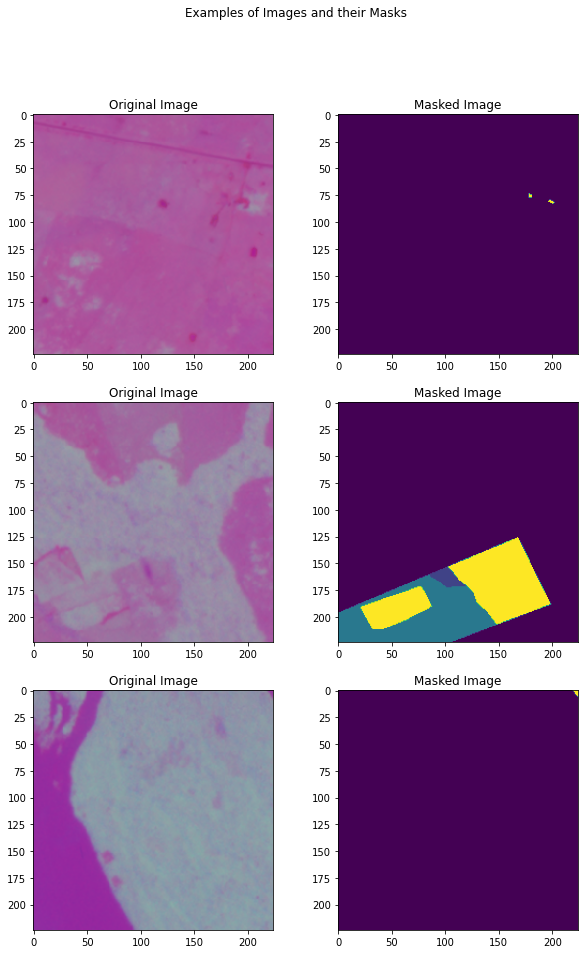

In [ ]:
display_num = 3

# select only for tiles with foreground labels present
foreground_list_x = []
foreground_list_y = []
for x,y in zip(x_train_filenames, y_train_filenames): 
    img = np.array(Image.open(y)) 
    if img.max()>0:
        foreground_list_x.append(x)
        foreground_list_y.append(y)

num_foreground_examples = len(foreground_list_y)

# randomlize the choice of image and label pairs
r_choices = np.random.choice(num_foreground_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = foreground_list_x[img_num]
  y_pathname = foreground_list_y[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  plt.title("Original Image")
  
  example_labels = Image.open(y_pathname)
  label_vals = np.unique(np.array(example_labels))
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()